In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import treelib

from collections import Counter, defaultdict

import arxiv_tag_lib as at

# ArXiv Tagger

Description of the project goes here...

## Database creation

Here we use the Nature metadata dataset to get the abstracts and keywords of the papers published on the publisher journal.

Since this is a proof of principle project, we focus on a small part of all possible paper, namely those with a keyword contianing *field theory*, as the dataset seems to contain a moderate amount of these articles.

In [3]:
# Set the API key for accessing the database
api_key = os.environ['SPRINGER_API_KEY']

# Create the query and the dataset
query = {'type':'Journal','keyword':"field theory"}
df = at.create_dataframe(query,api_key)
df.to_pickle('./dataset_field_theory.pkl')

## Selecting the labels

Contrary to how APS Journals work, the keywords used on Nature are not taken from a pre-defined set, and instead are assigned by the authors. A drowback of this is that there will be many different keywords and we'd like to select the most common to create the labels for our dataset.

### Cleaning the keywords

Let's start by cleaning up the keywords and getting an idea of the most common ones,

In [24]:
df = pd.read_pickle('./dataset_field_theory.pkl')

# Some paper have only one keyword that is saved outside a list
df['keywords'] = df['keywords'].apply(lambda item : [item] if type(item) == str else item)

df.tail()

,abstract,keywords
18063,The LSZ asymptotic condition and the Yang-Feld...,"[Neural Network, Statistical Physic, Field The..."
18064,The mathematical formalism describing the Bose...,"[Neural Network, Field Theory, Quantum Field T..."
18065,"We want to construct, for every local irreduci...","[Neural Network, Statistical Physic, Field The..."
18066,It is proved that if the n -point correlation ...,"[Neural Network, Statistical Physic, Field The..."
18067,Electromagnetic tensor field can be divided in...,"[Null Vector, Unify Field Theory, Electromagne..."


The number of different keywords is large, as we can see here,

In [25]:
tags = np.concatenate(df['keywords'].to_numpy())
unique_tags = np.unique(tags)

unique_tags.size

10765

We might be able to slightly reduce the tags if we clean them up
- set in lowercase
- neglect non-alphanumeric words
- stem and remove stopwords

Then we get,

In [26]:
# Select the stemmer and the corpus of stopwords
ps = PorterStemmer()
stp_en = stopwords.words('english')

# clean the tags
df['keywords'] = df['keywords'].apply(lambda item : at.clean_tags(item,ps,stp_en))
df.tail()

,abstract,keywords
18063,The LSZ asymptotic condition and the Yang-Feld...,"[neural network, statist physic, field theori,..."
18064,The mathematical formalism describing the Bose...,"[neural network, field theori, quantum field t..."
18065,"We want to construct, for every local irreduci...","[neural network, statist physic, field theori,..."
18066,It is proved that if the n -point correlation ...,"[neural network, statist physic, field theori,..."
18067,Electromagnetic tensor field can be divided in...,"[null vector, unifi field theori, electromagne..."


Let's check if we have indeed reduced a bit the number of tags,

In [27]:
tags = np.concatenate(df['keywords'].to_numpy())
unique_tags = np.unique(tags)

unique_tags.size

9404

Let's check the most common tags, to get an idea of what we are dealing with,

In [28]:
tags = np.concatenate(df['keywords'].to_numpy())
tags_frequency = Counter(tags)

tags_frequency.most_common(10)

[('field theori', 10159),
 ('elementari particl', 8981),
 ('quantum field theori', 8967),
 ('particl acceler', 1976),
 ('conform field theori', 1330),
 ('spectroscopi', 1257),
 ('effect field theori', 1118),
 ('state physic', 1077),
 ('ad cft correspond', 1053),
 ('field theori lower dimens', 872)]

It is clear that the first 3 tags (maybe even the 4th one) are a bit too general and we can probably remove them, since a lot of stuff falls broadly under these tags.

### Creating a hierarchy of tags

We now search for the important tags, and will restrict our dataset to the items that contains these tags. We do this by creating a tree of tags.

We can additionally use the hierarchical nature of how tags are assigned in the Nature dataset to only focus on the leafs of the tree and label the corresponding items with their tag.

**NOTE**: We move from a multi-label dataset to a multi-class one. This is not necessarily desirable and maybe in the future we'll try to go for a multi-label problem. For now, we try this approach to see how well we can still classify papers.

In [29]:
# Create the tags tree
tags_tree = treelib.Tree()

# List of tags to avoid (too many items link to them)
avoid_tags=['field theori','elementari particl','quantum field theori','particl acceler']

# Create the root node of the tree and build it
root = tags_tree.create_node('root',data=df.copy())
at.build_tag_tree(tags_tree,root.identifier,avoid_tags,min_size=250)

# Show the tree
tags_tree.show()

root
├── conform field theori
│   └── ad cft correspond
├── dualiti gaug field theori
├── effect field theori
│   └── beyond standard model
├── field theori higher dimens
├── field theori lower dimens
├── gaug theori
├── integr field theori
│   └── ad cft correspond
├── neural network
│   └── complex system
│       └── statist physic
├── quantum mechan
└── spectroscopi
    └── state physic



Let's visualize the size of each class, to see if the problem is balanced or not,

In [30]:
# Get the size of each class and the total size of the dataset we'll be left with
size_tag = defaultdict(int)
total_items = 0

for node in tags_tree.leaves():
    size_tag[node.tag] += node.data.shape[0]
    total_items += node.data.shape[0]
    
tags_number = len(size_tag)

# We can check how may instances of the same tags selected here are present in the full dataset
full_df_size_tag = [tags_frequency[key] for key in size_tag.keys()]

print('We use {} tags, for a grand total of {} items.'.format(tags_number,total_items))

We use 9 tags, for a grand total of 4696 items.


Before we visualize the classes, we'd like to check how many items in the original database contain the same labels. Notice that a single item might contain two or more of the keywords we are using, as they might overlap. 

Due to how we have constructed the tree of tags, we are dividing the items into non-overlapping categories (this might help avoiding having abstract too similar for different topics). However, by doing so we might be losing quite a few items. 

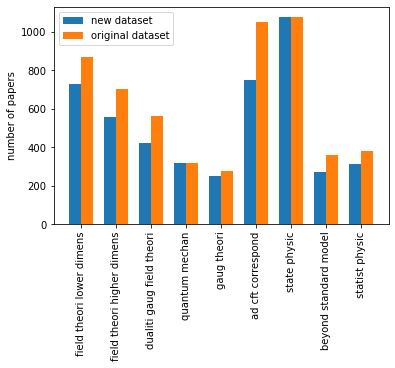

In [31]:
# Visualize the classes size
bar_width = 0.35
positions = np.arange(tags_number)

plt.bar(positions-bar_width/2,size_tag.values(),bar_width,label='new dataset')
plt.bar(positions+bar_width/2,full_df_size_tag,bar_width,label='original dataset')

plt.xticks(range(tags_number),size_tag.keys(),rotation='vertical')

plt.ylabel('number of papers')

plt.legend()
plt.show()

We are losing something, but not so much really. Might need to keep an eye on the *AdS-CFT correspondence* tag.

### Creating the dataset with fixed classes

We can now create the dataset out of the classes we have selected. 

In [44]:
df_tags = pd.DataFrame(columns=['abstract','keywords'])

for node in tags_tree.leaves():
    
    df_node = node.data.copy()
    df_node['keywords'] = node.tag
    
    df_tags = df_tags.append(df_node)

df_tags.reset_index(drop=True,inplace=True)
df_tags.to_pickle('./dataset_ft_classified.pkl')

## Cleaning the abstracts

We can now use standard NLP techniques to clean up the abstract field

In [46]:
df_tags = pd.read_pickle('./dataset_ft_classified.pkl')
df_tags.sample(n=7)

,abstract,keywords
813,We propose quantum states for Little String Th...,field theori higher dimens
3608,We present a theoretical study of the ultrasho...,state physic
2014,,quantum mechan
3614,Dynamics of double membrane films is investiga...,state physic
1407,We calculate the instanton partition function ...,dualiti gaug field theori
4240,We study three-point correlation functions of ...,ad cft correspond
897,All known interacting 6D superconformal field ...,field theori higher dimens


In [48]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4696 entries, 0 to 4695
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  4696 non-null   object
 1   keywords  4696 non-null   object
dtypes: object(2)
memory usage: 73.5+ KB
